In [1]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, ttest_rel

# ---------- paths (assumes same filename in each model's results dir)
BULK_FILE = "voom_bulk_10_fold_30_pcs_tissue_growth.csv"
PATHS = {
    "ElasticNet": f"01_simple_baselines/results/elastic_net/{BULK_FILE}",
    "RandomForest": f"02_complex_baselines/results/rf/{BULK_FILE}",
}

def load_bulk(path, model):
    df = pd.read_csv(path)
    df["Model"] = model
    # Normalize column names (match previous code)
    df.rename(columns=lambda c: c.strip().replace("²", "^2"), inplace=True)
    # Map r2_global/rmse -> r2_mean/rmse_mean for compatibility with plotting funcs
    if "r2_mean" not in df.columns and "r2_global" in df.columns:
        df = df.rename(columns={"r2_global":"r2_mean", "rmse":"rmse_mean"})
    # Ensure expected columns exist
    needed = {"DRUG_ID","n_samples","r2_mean","rmse_mean","pearson_r","pearson_pval","Model"}
    missing = sorted(list(needed - set(df.columns)))
    if missing:
        raise ValueError(f"Missing columns in {path}: {missing}")
    return df[["DRUG_ID","n_samples","r2_mean","rmse_mean",
            "pearson_r","pearson_pval",
            "spearman_r","spearman_pval","Model"]]

frames = [load_bulk(p, m) for m,p in PATHS.items()]
bulk_df = pd.concat(frames, ignore_index=True)
print("✅ combined:", bulk_df.shape)
bulk_df.head()


✅ combined: (1250, 9)


,DRUG_ID,n_samples,r2_mean,rmse_mean,pearson_r,pearson_pval,spearman_r,spearman_pval,Model
0,133,132,0.042170,1.658243,0.207873,0.016768,0.188408,0.030505,ElasticNet
1,134,132,0.052034,1.861967,0.230291,0.007896,0.242595,0.005068,ElasticNet
2,135,131,0.053810,2.538988,0.246203,0.004587,0.269161,0.001879,ElasticNet
3,136,133,0.016416,1.494454,0.173342,0.046006,0.139557,0.109132,ElasticNet
4,140,133,0.049421,1.597350,0.222344,0.010103,0.213903,0.013427,ElasticNet


In [2]:
# %%
pretty_map = {"ElasticNet":"Elastic Net","RandomForest":"Random Forest"}
df_plot = bulk_df.copy()
df_plot["ModelPretty"] = df_plot["Model"].map(pretty_map)


In [3]:
# %% helpers for stats + plots
def paired_model_tests(df, metric="r2_mean"):
    """Paired EN vs RF per drug. Positive delta => RF better."""
    wide = df.pivot_table(index="DRUG_ID", columns="Model", values=metric, aggfunc="mean").dropna()
    if wide.empty: 
        return None
    x, y = wide["RandomForest"], wide["ElasticNet"]
    if metric in ("r2_mean","pearson_r"):  # higher is better
        d = x - y
    else:  # rmse_mean: lower is better
        d = y - x
    n = len(d)
    return {
        "n": n,
        "delta_mean": d.mean(),
        "delta_median": d.median(),
        "win_rate": (d > 0).mean(),  # fraction where RF wins
        "wilcoxon_p": wilcoxon(d, zero_method="pratt").pvalue if n>=5 else np.nan,
        "ttest_p": ttest_rel(x, y, nan_policy="omit").pvalue if n>=5 else np.nan
    }

def agg_stats(df, metric):
    g = (
        df.groupby(["ModelPretty"], as_index=False)[metric]
          .agg(mean="mean", std="std", n="count")
    )
    g["se"] = g["std"] / np.sqrt(g["n"])
    g["ci95"] = 1.96 * g["se"]
    g["metric"] = metric
    return g.rename(columns={"mean":"Mean","std":"Std","n":"N","ci95":"95% CI"})

def nice_boxplot(df, x, title, legend_title="Model"):
    fig, ax = plt.subplots(figsize=(8, 3.6))
    sns.boxplot(
        data=df, x=x, y="ModelPretty", hue="ModelPretty",
        palette="muted", showfliers=False, dodge=False, ax=ax,
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
        medianprops=dict(linewidth=1.0),
    )
    # label on top to save space
    ax.set_title(title, fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel({"r2_mean":"R²", "rmse_mean":"RMSE"}.get(x, x), fontsize=10, labelpad=2)
    ax.set_ylabel("")

    # slim legend (reuse handles/labels, set outside)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2],
              title=legend_title, frameon=False, loc="upper left",
              bbox_to_anchor=(1.01, 1.0), fontsize=9, title_fontsize=10,
              handlelength=0.9, borderpad=0.2, labelspacing=0.25)

    # cosmetics
    for sp in ax.spines.values(): sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
    plt.subplots_adjust(left=0.14, right=0.98, top=0.88, bottom=0.08)
    plt.show()


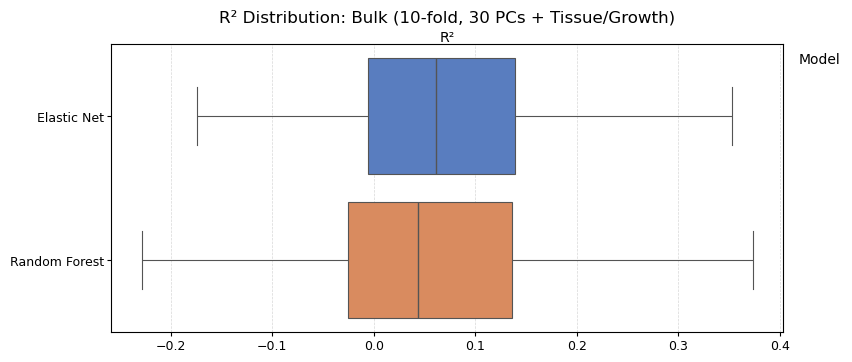

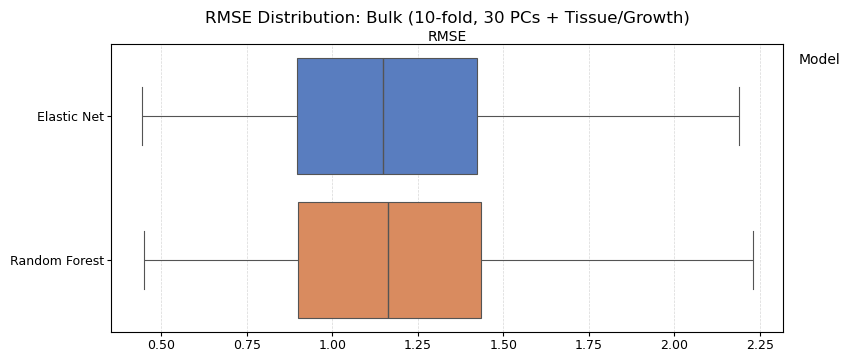

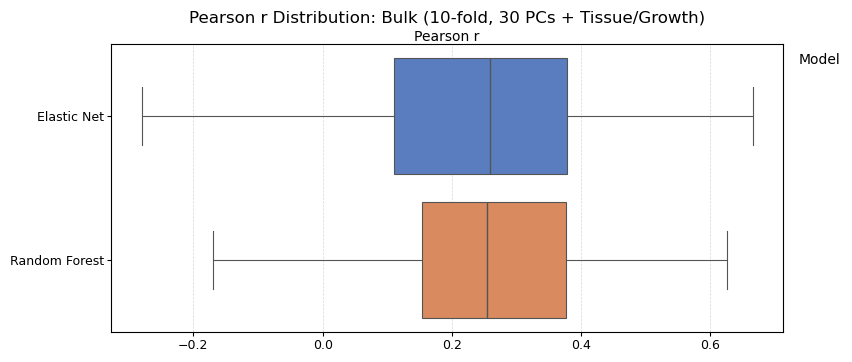

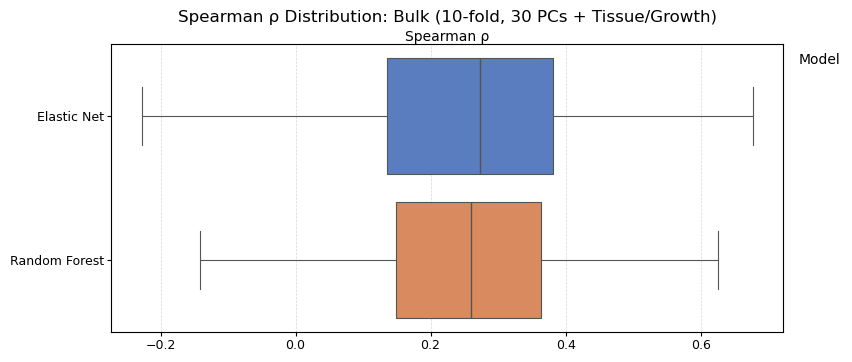

In [4]:
# %% boxplots (R², RMSE, Pearson r)
nice_boxplot(df_plot, x="r2_mean",  title="R² Distribution: Bulk (10-fold, 30 PCs + Tissue/Growth)")
nice_boxplot(df_plot, x="rmse_mean", title="RMSE Distribution: Bulk (10-fold, 30 PCs + Tissue/Growth)")

# Pearson r uses same style but different x-label
fig, ax = plt.subplots(figsize=(8, 3.6))
sns.boxplot(
    data=df_plot, x="pearson_r", y="ModelPretty", hue="ModelPretty",
    palette="muted", showfliers=False, dodge=False, ax=ax,
    boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
    capprops=dict(linewidth=0.8), medianprops=dict(linewidth=1.0),
)
ax.set_title("Pearson r Distribution: Bulk (10-fold, 30 PCs + Tissue/Growth)", fontsize=12)
ax.xaxis.set_label_position('top'); ax.set_xlabel("Pearson r", fontsize=10, labelpad=2); ax.set_ylabel("")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Model", frameon=False, loc="upper left",
          bbox_to_anchor=(1.01, 1.0), fontsize=9, title_fontsize=10,
          handlelength=0.9, borderpad=0.2, labelspacing=0.25)
for sp in ax.spines.values(): sp.set_linewidth(0.8)
ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
plt.subplots_adjust(left=0.14, right=0.98, top=0.88, bottom=0.08)
plt.show()

# %%
# %% boxplot (Spearman ρ)
fig, ax = plt.subplots(figsize=(8, 3.6))
sns.boxplot(
    data=df_plot, x="spearman_r", y="ModelPretty", hue="ModelPretty",
    palette="muted", showfliers=False, dodge=False, ax=ax,
    boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
    capprops=dict(linewidth=0.8), medianprops=dict(linewidth=1.0),
)
ax.set_title("Spearman ρ Distribution: Bulk (10-fold, 30 PCs + Tissue/Growth)", fontsize=12)
ax.xaxis.set_label_position('top'); ax.set_xlabel("Spearman ρ", fontsize=10, labelpad=2); ax.set_ylabel("")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Model", frameon=False, loc="upper left",
          bbox_to_anchor=(1.01, 1.0), fontsize=9, title_fontsize=10,
          handlelength=0.9, borderpad=0.2, labelspacing=0.25)
for sp in ax.spines.values(): sp.set_linewidth(0.8)
ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
plt.subplots_adjust(left=0.14, right=0.98, top=0.88, bottom=0.08)
plt.show()



In [5]:
# %% paired tests: RF vs EN per drug (positive delta = RF better)
rows = []
for metric, nice in [("r2_mean","R² (RF - EN)"),
                     ("rmse_mean","RMSE (EN - RF)"),   # lower is better
                     ("pearson_r","Pearson r (RF - EN)"),
                     ("spearman_r","Spearman ρ (RF - EN)")]:
    out = paired_model_tests(bulk_df, metric)
    if out:
        rows.append({"Metric": nice, **out})
paired_summary = pd.DataFrame(rows)
display(paired_summary)


,Metric,n,delta_mean,delta_median,win_rate,wilcoxon_p,ttest_p
0,R² (RF - EN),625,-0.020057,-0.019702,0.3904,1.379559e-12,8.802750e-14
1,RMSE (EN - RF),625,-0.012167,-0.010365,0.3904,1.901278e-11,8.267957e-12
2,Pearson r (RF - EN),625,0.025916,0.013504,0.5536,7.020590e-06,2.751859e-09
3,Spearman ρ (RF - EN),625,-0.017805,0.000424,0.5024,8.308232e-02,1.004995e-04


In [6]:
# %% aggregate stats per model (R², RMSE, Pearson r, Spearman ρ)
summary_table = pd.concat([
    agg_stats(df_plot, "r2_mean"),
    agg_stats(df_plot, "rmse_mean"),
    agg_stats(df_plot, "pearson_r"),
    agg_stats(df_plot, "spearman_r"),
], ignore_index=True)

display(summary_table[["metric","ModelPretty","N","Mean","Std","95% CI"]].round(4))


,metric,ModelPretty,N,Mean,Std,95% CI
0,r2_mean,Elastic Net,625,0.0776,0.1060,0.0083
1,r2_mean,Random Forest,625,0.0575,0.1185,0.0093
2,rmse_mean,Elastic Net,625,1.1847,0.3787,0.0297
3,rmse_mean,Random Forest,625,1.1969,0.3832,0.0300
4,pearson_r,Elastic Net,625,0.2356,0.2035,0.0160
5,pearson_r,Random Forest,625,0.2615,0.1600,0.0125
6,spearman_r,Elastic Net,625,0.2395,0.2058,0.0161
7,spearman_r,Random Forest,625,0.2573,0.1513,0.0119


In [7]:
# %% proportion of significant correlations (p < 0.05) per model
sig_rates = (
    df_plot.assign(sig = df_plot["pearson_pval"] < 0.05)
           .groupby("ModelPretty")["sig"]
           .agg(rate="mean", N="count")
           .reset_index()
)
sig_rates["rate"] = (100*sig_rates["rate"]).round(1)
sig_rates.rename(columns={"rate":"% Pearson p<0.05"}, inplace=True)
display(sig_rates)


,ModelPretty,% Pearson p<0.05,N
0,Elastic Net,72.2,625
1,Random Forest,71.5,625


,Metric,RF wins,EN wins,Ties,RF win rate (no ties),Sign test p
0,r2_mean,235,373,17,0.386513,2.415459e-08


,Metric,RF wins,EN wins,Ties,RF win rate (no ties),Sign test p
0,rmse_mean,216,339,70,0.389189,2.003138e-07


,Metric,RF wins,EN wins,Ties,RF win rate (no ties),Sign test p
0,pearson_r,322,253,50,0.56,0.00453


,Metric,RF wins,EN wins,Ties,RF win rate (no ties),Sign test p
0,spearman_r,287,290,48,0.4974,0.933653


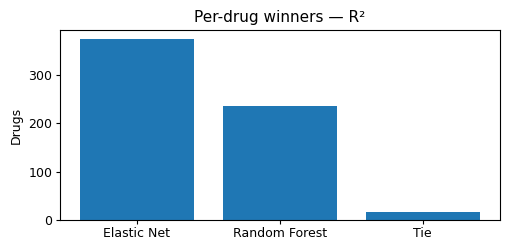

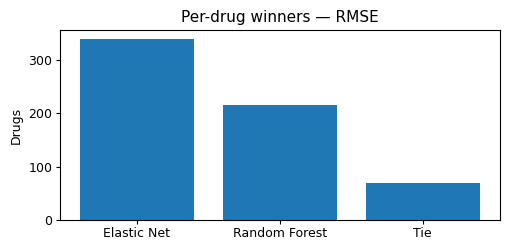

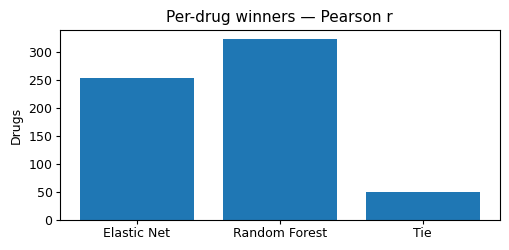

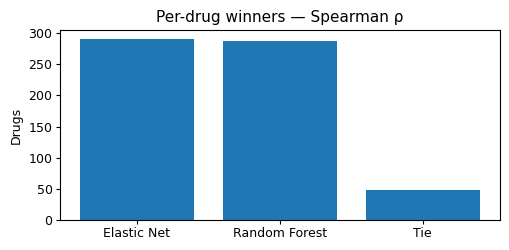

In [8]:
# %% per-drug winners, counts, and sign tests
import numpy as np
from scipy.stats import binomtest

def per_drug_wins(df, metric, tie_tol=0.002):
    # wide table: one row per DRUG_ID with EN/RF values
    wide = (df.pivot_table(index="DRUG_ID", columns="Model", values=metric, aggfunc="mean")
              .dropna(subset=["ElasticNet","RandomForest"]))
    if wide.empty:
        return None, None, None

    if metric in ("r2_mean", "pearson_r", "spearman_r"):   # higher is better
        d = wide["RandomForest"] - wide["ElasticNet"]   # positive => RF better
    else:  # rmse_mean: lower is better
        d = wide["ElasticNet"] - wide["RandomForest"]   # positive => RF better (lower RMSE)

    winners = np.where(d >  tie_tol, "Random Forest",
               np.where(d < -tie_tol, "Elastic Net", "Tie"))
    wide = wide.assign(delta=d, winner=winners)

    # counts
    counts = (pd.Series(winners).value_counts()
                .reindex(["Elastic Net","Random Forest","Tie"], fill_value=0)
                .rename("count"))
    n_non_ties = int((winners != "Tie").sum())
    n_rf = int((winners == "Random Forest").sum())

    # two-sided sign test: H0 win rate = 0.5 among non-ties
    sign_p = binomtest(n_rf, n_non_ties, 0.5, alternative="two-sided").pvalue if n_non_ties>0 else np.nan

    summary = pd.DataFrame({
        "Metric":[metric],
        "RF wins":[n_rf],
        "EN wins":[int((winners == "Elastic Net").sum())],
        "Ties":[int((winners == "Tie").sum())],
        "RF win rate (no ties)":[n_rf / n_non_ties if n_non_ties else np.nan],
        "Sign test p":[sign_p]
    })
    return wide, counts, summary

wide_r2,      counts_r2,      summary_r2      = per_drug_wins(bulk_df, "r2_mean",   tie_tol=0.002)  # ~0.2 R² points
wide_rmse,    counts_rmse,    summary_rmse    = per_drug_wins(bulk_df, "rmse_mean", tie_tol=0.005)  # ~0.005 RMSE units
wide_r,       counts_r,       summary_r       = per_drug_wins(bulk_df, "pearson_r", tie_tol=0.01)   # ~0.01 r
wide_spearman,counts_spearman,summary_spearman= per_drug_wins(bulk_df, "spearman_r", tie_tol=0.01)   # ~0.01 ρ

display(summary_r2)
display(summary_rmse)
display(summary_r)
display(summary_spearman)

# quick bar charts of win/tie counts (same compact style)
def win_bar(counts, title):
    fig, ax = plt.subplots(figsize=(5.2,2.6))
    order = ["Elastic Net","Random Forest","Tie"]
    vals = counts.reindex(order, fill_value=0)
    ax.bar(order, vals.values)
    ax.set_title(title, fontsize=11)
    ax.set_ylabel("Drugs", fontsize=9)
    ax.tick_params(axis="x", labelsize=9)
    for sp in ax.spines.values(): sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    plt.tight_layout(); plt.show()

win_bar(counts_r2,       "Per-drug winners — R²")
win_bar(counts_rmse,     "Per-drug winners — RMSE")
win_bar(counts_r,        "Per-drug winners — Pearson r")
win_bar(counts_spearman, "Per-drug winners — Spearman ρ")
